In [1]:
import os
import glob
import csv

In [13]:
split = 'test'
PARENT = "/data/holly_jackson/experiments/"#nyuv2-"+split+"-v3"
# out_csv = "summary_metrics_all_"+split+"_nyuv2_v4.csv"
# exp_name_format = "coord-descent-aif-init-????_2025-08-20_*"
exp_name_format = "all-"+split+"-????_2025-08-2*"#"nyuv2-"+split+"*"#

In [14]:
def parse_last_loss(losses_path):
    # todo: this reads whole file not super efficient
    with open(losses_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip(): # not blank
                last = line.strip()
    return float(last)

def parse_accuracy_metrics(metrics_path):
    rms = rel = d1 = d2 = d3 = None
    with open(metrics_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line.lower().startswith("rms"):
                rms = float(line.split(":")[1].strip())
            elif line.lower().startswith("rel"):
                rel = float(line.split(":")[1].strip())
            elif line.lower().startswith("accuracy"):
                right = line.split(":")[1].strip()
                d1, d2, d3 = [float(x.strip()) for x in right.split(",")]
    return (rms, rel, d1, d2, d3)

In [15]:

pattern = os.path.join(PARENT, exp_name_format)
dirs = [d for d in glob.glob(pattern) if os.path.isdir(d)]

# dirs = [d for d in os.listdir(PARENT) if os.path.isdir(os.path.join(PARENT, d))]

# remove repeats + sort
dirs = sorted(set(dirs))
print(len(dirs))

# print(dirs)

654


In [16]:
rows = []

for d in dirs:
    # print(d)
    run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    # run_id = os.path.basename(d).split("nyuv2-"+split+"-")[1].split("_")[0]
    # print(run_id)
    # break
        
    losses_path = os.path.join(PARENT, d, "losses.txt")
    metrics_path = os.path.join(PARENT, d, "accuracy_metrics.txt")

    if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
        continue
    
    last_loss = parse_last_loss(losses_path)
    # print(last_loss)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
    # print(rms, rel, d1, d2, d3)

    rows.append({
        "run_id": run_id,
        "last_loss": last_loss,
        "RMS": rms,
        "Rel": rel,
        "delta1": d1,
        "delta2": d2,
        "delta3": d3,
    })


# # write to csv all at once
# fieldnames = ["run_id", "last_loss", "RMS", "Rel", "delta1", "delta2", "delta3"]
# rows.sort(key=lambda r: r["run_id"])

# avg_row = {"run_id": "AVERAGE"}
# for col in fieldnames[1:]:
#     values = [r[col] for r in rows if r[col] is not None]
#     avg_row[col] = sum(values) / len(values) if values else None

# rows.append(avg_row)

# with open(out_csv, "w", newline="", encoding="utf-8") as f:
#     writer = csv.DictWriter(
#         f,
#         fieldnames=fieldnames
#     )
#     writer.writeheader()
#     writer.writerows(rows)

# print(f"Wrote {len(rows)} rows to {out_csv}")

In [17]:
import utils 
import forward_model
import globals

globals.init_NYUv2()

IMAGE_RANGE = 255.

# load data 
gt_aif, gt_dpt = utils.load_single_sample(sample='0045', set='train', fs=5, res='half')
# gt_aif, gt_dpt, _ = utils.load_sample_image(fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

width, height = gt_dpt.shape

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

defocus_stack = forward_model.forward(gt_dpt, gt_aif)


adaptive kernel size set to 11
precomputing indices


precomputing indices
0.001995 0.0019951062


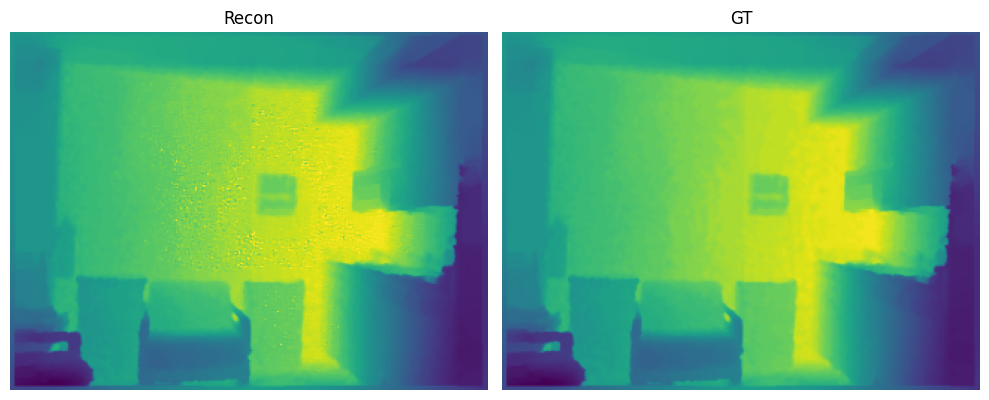

Removing outliers...
found 365 outliers


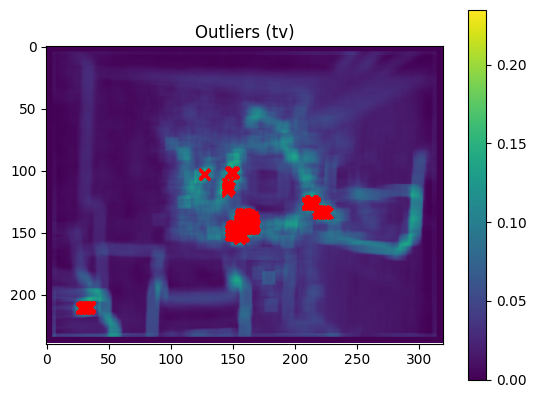

365 / 365 outliers removed


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

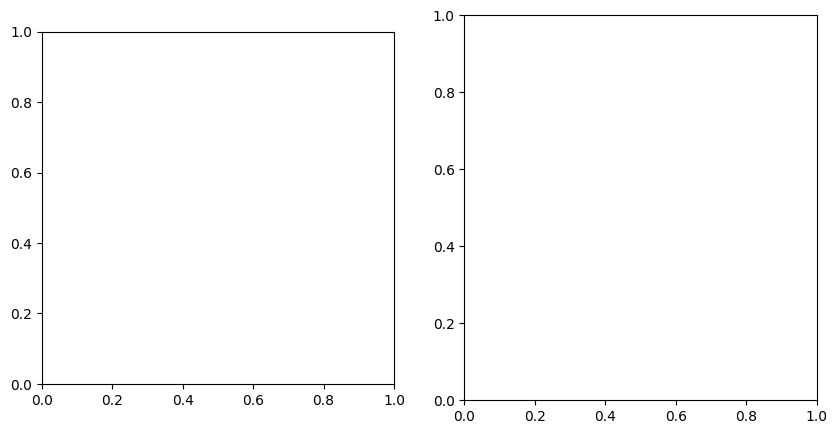

In [18]:
import matplotlib.pyplot as plt
import section_search
import utils
import math

count = 0

worst_rms = 0
worst_file = None
best_rms = float('inf')
best_file = None

for d in dirs:

    # print(d)
    run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    # print(run_id)
        
    losses_path = os.path.join(d, "losses.txt")
    metrics_path = os.path.join(d, "accuracy_metrics.txt")

    if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
        continue

    last_loss = parse_last_loss(losses_path)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)

    if rms > worst_rms:
        worst_rms = rms
        worst_file = d
    if rms < best_rms:
        best_rms = rms
        best_file = d
    
    dpt_test = utils.load_NYUv2_dpt(os.path.join(d, "dpt.tiff"), 1)
    aif_test = utils.load_NYUv2_aif(os.path.join(d, "aif.tiff"), 1) * IMAGE_RANGE
        
    defocus_stack_test = forward_model.forward(dpt_test, aif_test)

    gt_aif, gt_dpt = utils.load_single_sample(sample=run_id, set=split, fs=5, res='half')
    gt_aif = gt_aif * IMAGE_RANGE

    absrel = utils.compute_AbsRel(dpt_test, gt_dpt)
    print(rel, absrel)
    assert math.isclose(absrel, rel, rel_tol=1e-5, abs_tol=1e-5)

    
    utils.plot_compare_greyscale(dpt_test, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    plt.show()

    # TODO: need to fix this code but after entire set runs 
    dpt_no_outliers = section_search.remove_outliers(
        dpt_test, aif_test, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
    
    utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    plt.show()
    
    utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
    plt.show()


    

    print('mse:',last_loss, ', rms:', rms)
    
    count += 1
    


In [ ]:
import utils
import os
import coordinate_descent


d = worst_file
dpt_test = utils.load_NYUv2_dpt(os.path.join(d, "dpt.tiff"), 1)
aif_test = utils.load_NYUv2_aif(os.path.join(d, "aif.tiff"), 1) * IMAGE_RANGE

run_id = os.path.basename(d).split("_")[0].split("-")[-1]

losses_path = os.path.join(d, "losses.txt")
metrics_path = os.path.join(d, "accuracy_metrics.txt")

last_loss = parse_last_loss(losses_path)
rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
print(last_loss, rms, rel)

defocus_stack_test = forward_model.forward(dpt_test, aif_test)

gt_aif, gt_dpt = utils.load_single_sample(sample=run_id, set='test', fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

utils.plot_compare_greyscale(dpt_test, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()

# plt.imsave(
#     "figures/NYUv2_recon_DPT_worst_RMS_train.png",
#     dpt_test,
#     cmap="viridis",
#     vmin=gt_dpt.min(), vmax=gt_dpt.max(),
#     origin="upper",
# )

# # TODO: need to fix this code but after entire set runs 
dpt_no_outliers, _ = section_search.remove_outliers(
    dpt_test, aif_test, diff_thresh = 2, tv_thresh = 0.4, patch_type = 'tv')

defocus_stack_test_no_outliers = forward_model.forward(dpt_no_outliers, aif_test)

utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()
print('new RMS', utils.compute_RMS(dpt_no_outliers, gt_dpt))
print('new MSE', coordinate_descent.mse_loss(
    defocus_stack_test_no_outliers, defocus_stack))

utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
plt.show()


# # save everything for figures

# plt.imsave(
#     "figures/NYUv2_recon_AIF_worst_RMS_train.png",
#     aif_test / IMAGE_RANGE,
#     origin="upper",
# )

# plt.imsave(
#     "figures/NYUv2_gt_AIF_worst_RMS_train.png",
#     gt_aif / IMAGE_RANGE,
#     origin="upper",
# )


# plt.imsave(
#     "figures/NYUv2_recon_DPT_NOOUTLIER_TVTHRESH_4e-1_worst_RMS_train.png",
#     dpt_no_outliers,
#     cmap="viridis",
#     vmin=gt_dpt.min(), vmax=gt_dpt.max(),
#     origin="upper",
# )

# plt.imsave(
#     "figures/NYUv2_gt_DPT_worst_RMS_train.png",
#     gt_dpt,
#     cmap="viridis",
#     vmin=gt_dpt.min(), vmax=gt_dpt.max(),
#     origin="upper",
# )

In [ ]:

d = best_file
dpt_test = utils.load_NYUv2_dpt(os.path.join(d, "dpt.tiff"), 1)
aif_test = utils.load_NYUv2_aif(os.path.join(d, "aif.tiff"), 1) * IMAGE_RANGE

run_id = os.path.basename(d).split("_")[0].split("-")[-1]

losses_path = os.path.join(d, "losses.txt")
metrics_path = os.path.join(d, "accuracy_metrics.txt")

last_loss = parse_last_loss(losses_path)
rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
print(last_loss, rms, rel)

defocus_stack_test = forward_model.forward(dpt_test, aif_test)

gt_aif, gt_dpt = utils.load_single_sample(sample=run_id, set='test', fs=5, res='half')
gt_aif = gt_aif * IMAGE_RANGE

utils.plot_compare_greyscale(dpt_test, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()

utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
plt.show()


# save everything for figures

# plt.imsave(
#     "figures/NYUv2_recon_AIF_best_RMS_train.png",
#     aif_test / IMAGE_RANGE,
#     origin="upper",
# )

# plt.imsave(
#     "figures/NYUv2_gt_AIF_best_RMS_train.png",
#     gt_aif / IMAGE_RANGE,
#     origin="upper",
# )

# plt.imsave(
#     "figures/NYUv2_recon_DPT_best_RMS_train.png",
#     dpt_test,
#     cmap="viridis",
#     vmin=gt_dpt.min(), vmax=gt_dpt.max(),
#     origin="upper",
# )

# plt.imsave(
#     "figures/NYUv2_gt_DPT_best_RMS_train.png",
#     gt_dpt,
#     cmap="viridis",
#     vmin=gt_dpt.min(), vmax=gt_dpt.max(),
#     origin="upper",
# )

0.0017631171504035592 0.068942 0.00428
precomputing indices


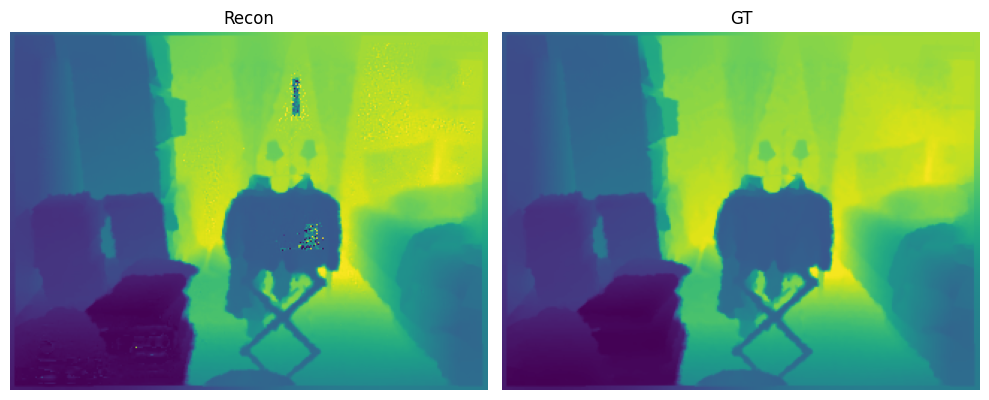

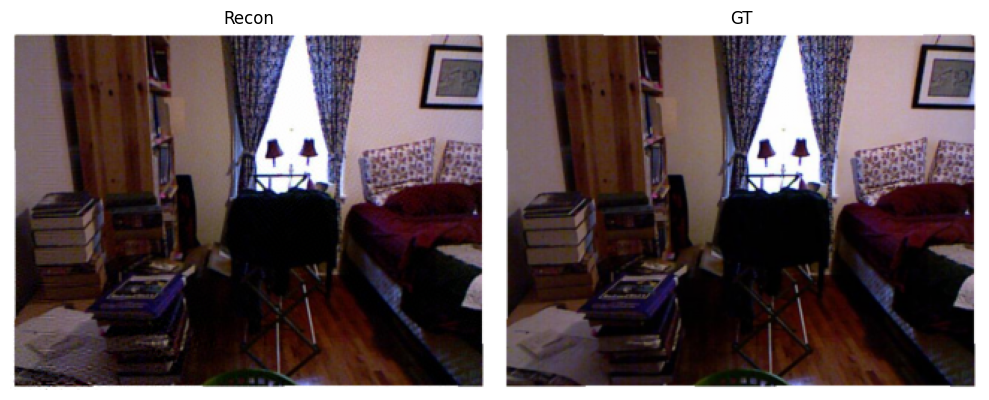

0.0007695016684010625 0.031716 0.002184
precomputing indices


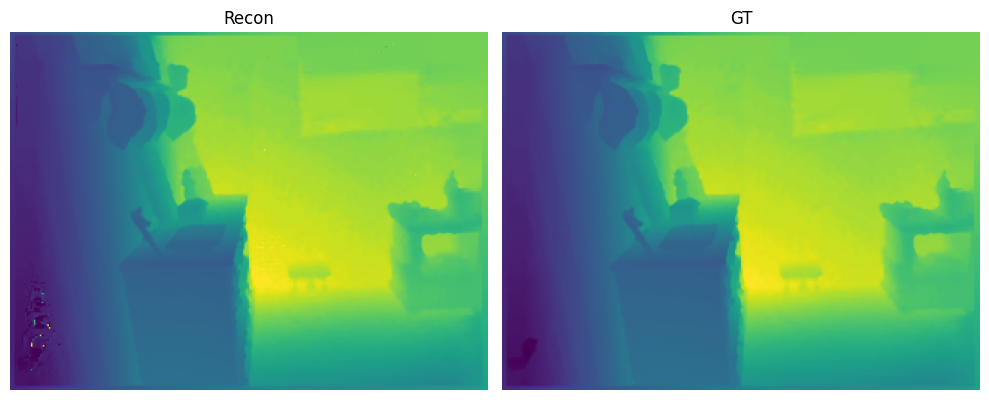

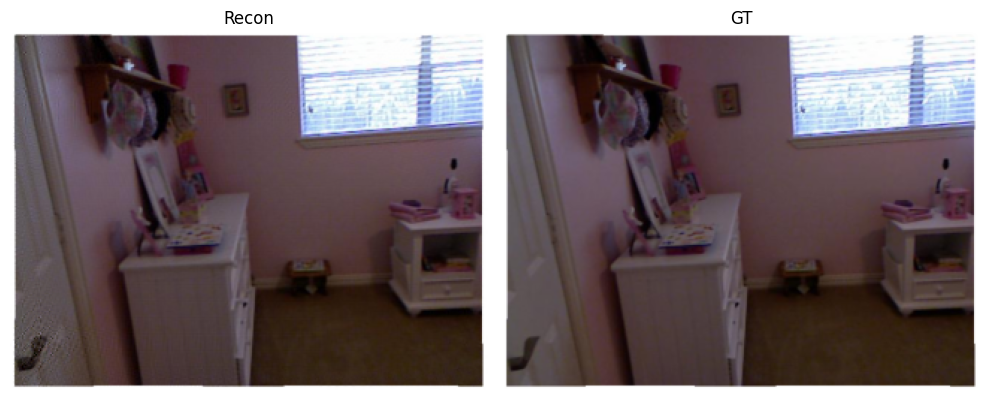

0.0006124358624219894 0.010278 0.001011
precomputing indices


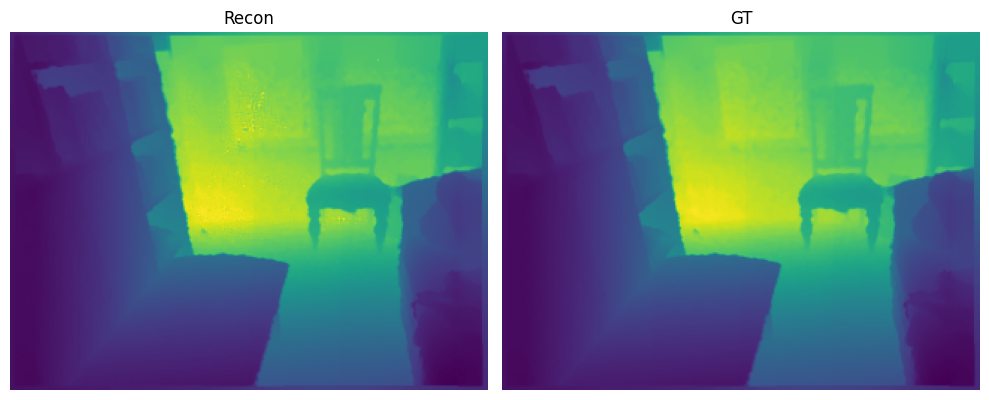

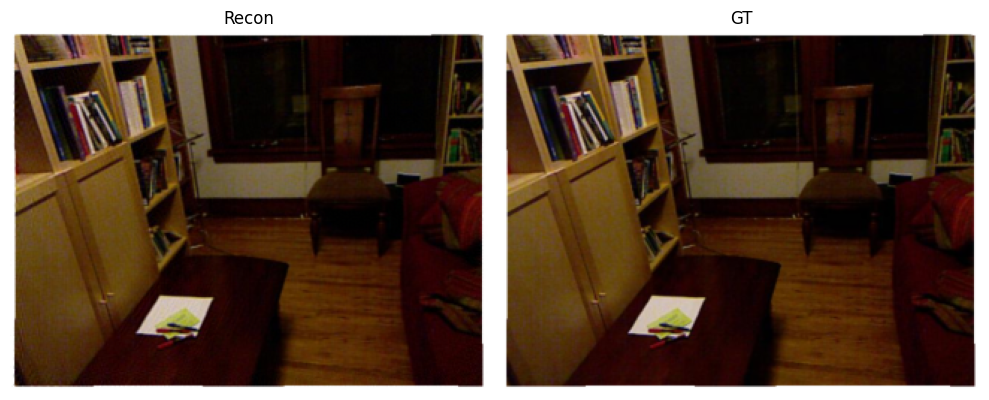

7.383825141005218e-05 0.014974 0.001147
precomputing indices


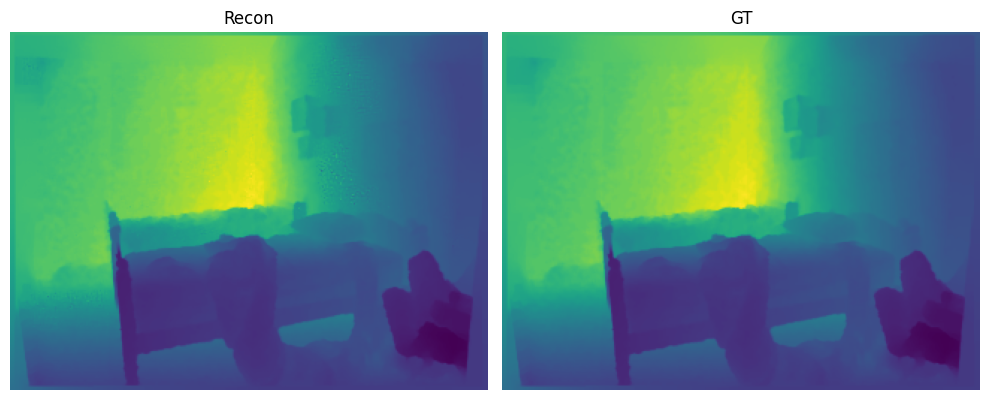

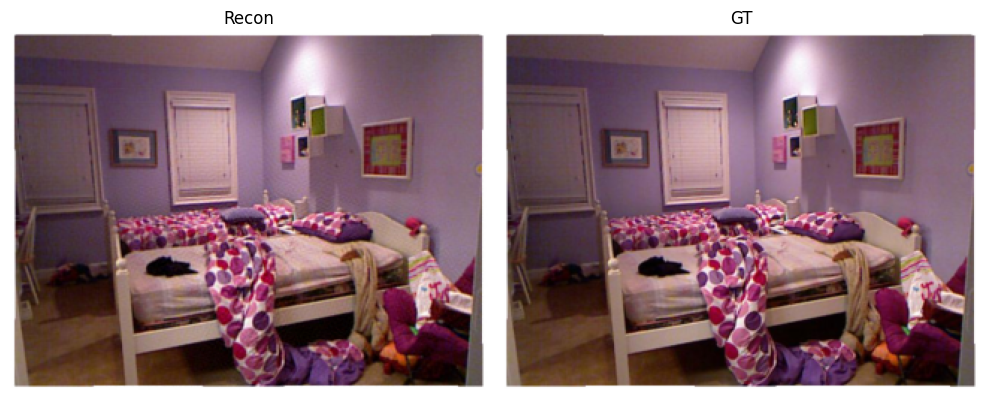

5.831813905388117e-05 0.017778 0.001441
precomputing indices


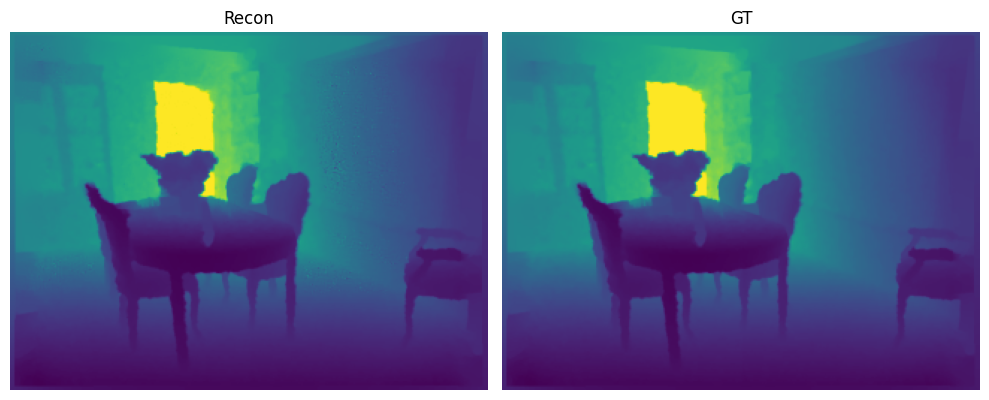

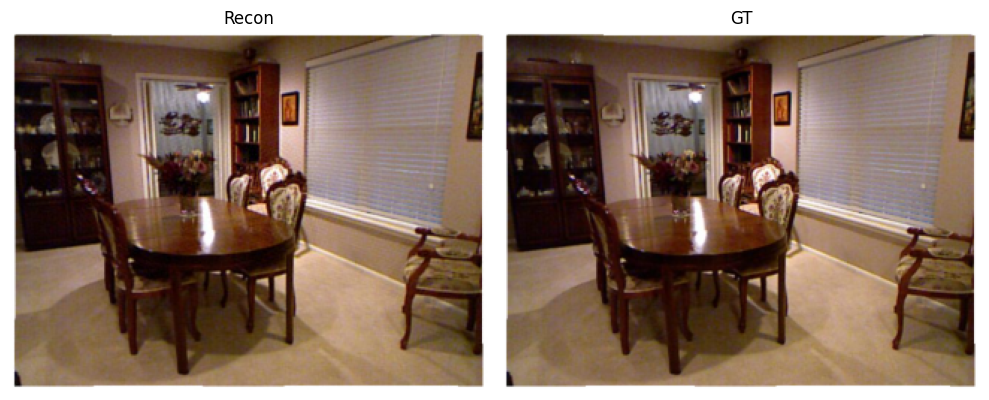

0.00010494847811060026 0.412138 0.016601
precomputing indices


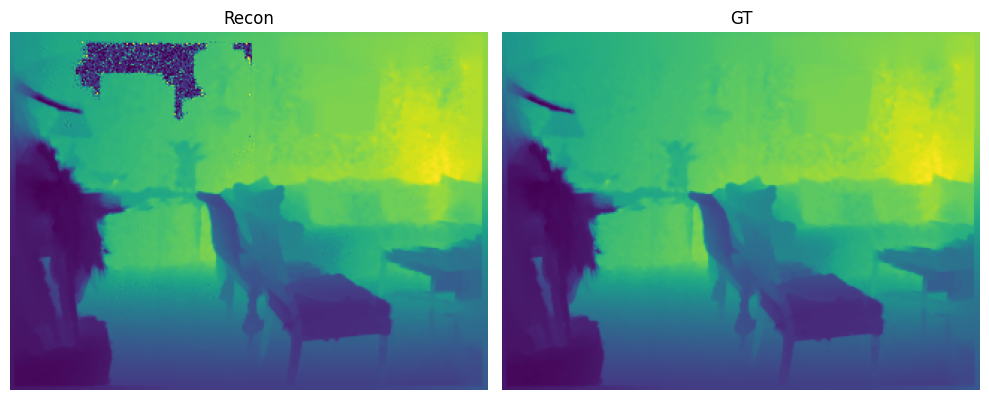

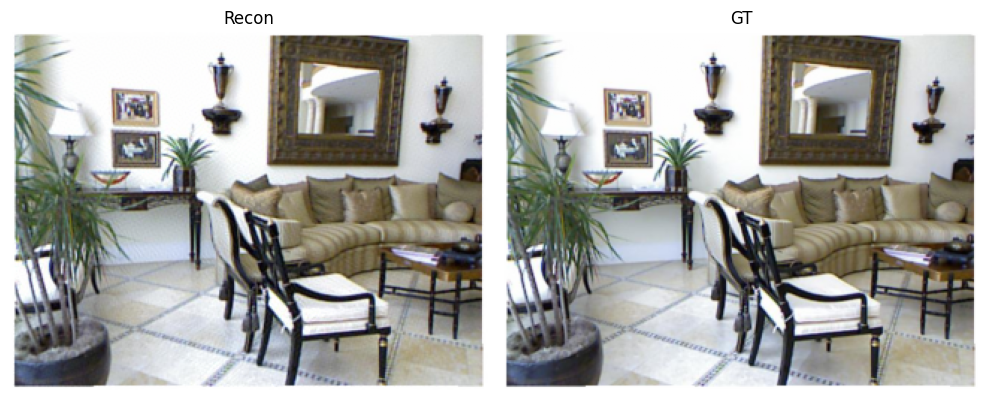

0.00015517944120801985 0.020399 0.001535
precomputing indices


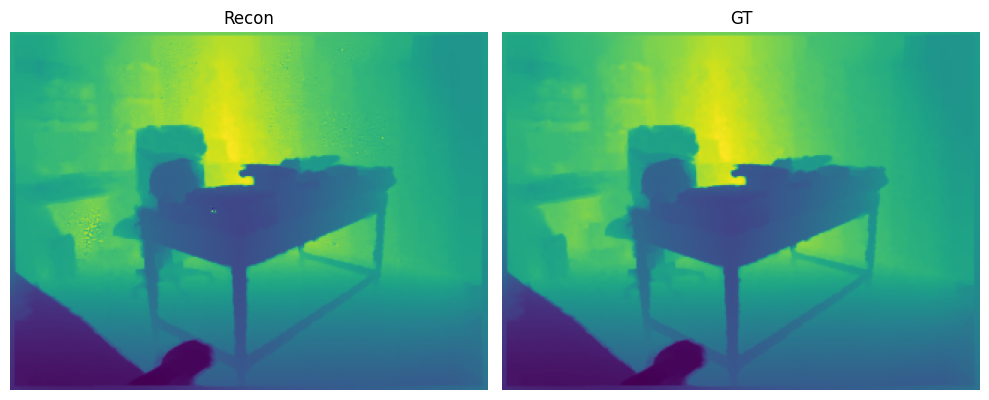

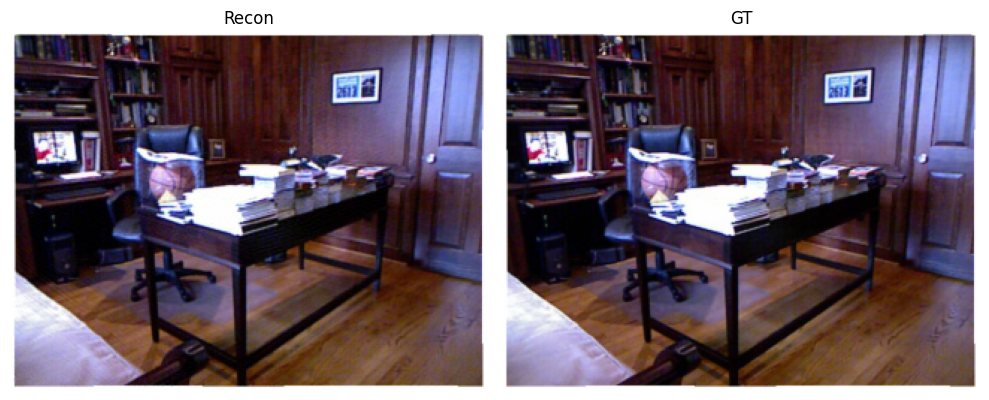

5.8527832152321935e-05 1.396605 0.066041
precomputing indices


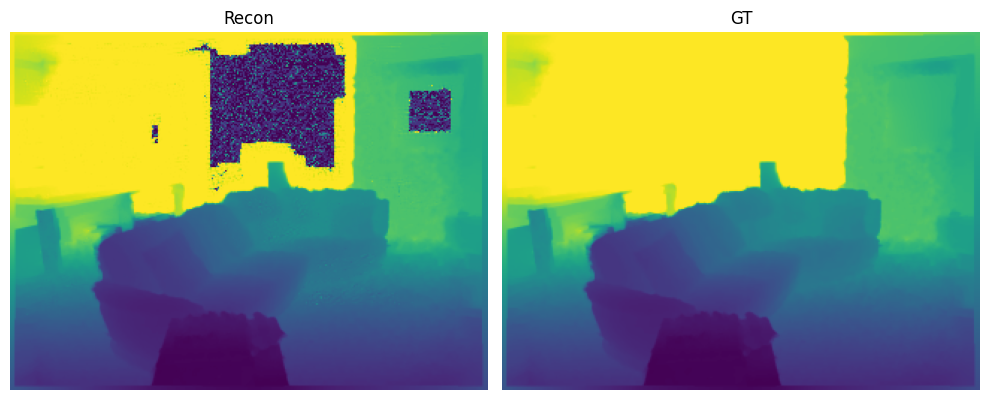

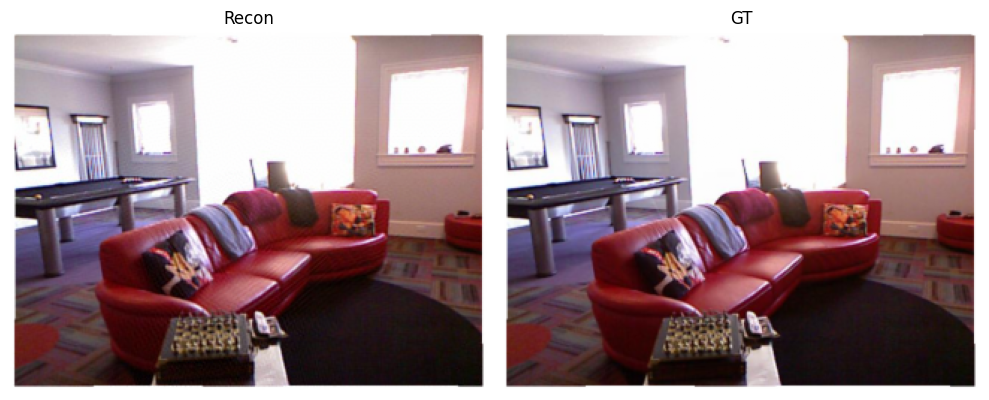

In [20]:
import random
# Choose 4 random examples to save
examples = random.sample(dirs, 8)

all_metrics = []

for i in range(len(examples)):
    d = examples[i]
    dpt_test = utils.load_NYUv2_dpt(os.path.join(d, "dpt.tiff"), 1)
    aif_test = utils.load_NYUv2_aif(os.path.join(d, "aif.tiff"), 1) * IMAGE_RANGE
    
    run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    
    losses_path = os.path.join(d, "losses.txt")
    metrics_path = os.path.join(d, "accuracy_metrics.txt")
    
    last_loss = parse_last_loss(losses_path)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)
    print(last_loss, rms, rel)
    all_metrics.append((i, rms, rel, d1, d2, d3))
    
    defocus_stack_test = forward_model.forward(dpt_test, aif_test)
    
    gt_aif, gt_dpt = utils.load_single_sample(sample=run_id, set=split, fs=5, res='half')
    gt_aif = gt_aif * IMAGE_RANGE
    
    utils.plot_compare_greyscale(dpt_test, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    plt.show()
    
    utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
    plt.show()
    
    
    # save everything for figures
    
    plt.imsave(
        "figures/supp/NYUv2_recon_AIF_example"+str(i)+"_"+split+".png",
        aif_test / IMAGE_RANGE,
        origin="upper",
    )
    
    plt.imsave(
        "figures/supp/NYUv2_gt_AIF_example"+str(i)+"_"+split+".png",
        gt_aif / IMAGE_RANGE,
        origin="upper",
    )
    
    plt.imsave(
        "figures/supp/NYUv2_recon_DPT_example"+str(i)+"_"+split+".png",
        dpt_test,
        cmap="viridis",
        vmin=gt_dpt.min(), vmax=gt_dpt.max(),
        origin="upper",
    )
    
    plt.imsave(
        "figures/supp/NYUv2_gt_DPT_example"+str(i)+"_"+split+".png",
        gt_dpt,
        cmap="viridis",
        vmin=gt_dpt.min(), vmax=gt_dpt.max(),
        origin="upper",
    )

with open("figures/supp/metrics_"+split+".txt", "w") as f:
    for (i, rms, rel, d1, d2, d3) in all_metrics:
        f.write(f"{i}: rms {rms}, rel {rel}, d1 {d1}, d2 {d2}, d3 {d3}\n")


In [ ]:
import matplotlib.pyplot as plt
import section_search
import utils
import math


count = 0
worst_rms = 0
worst_file = None
best_rms = 0
best_file = None

for d in dirs:

    # print(d)
    run_id = os.path.basename(d).split("_")[0].split("-")[-1]
    # print(run_id)
        
    losses_path = os.path.join(d, "losses.txt")
    metrics_path = os.path.join(d, "accuracy_metrics.txt")

    if not os.path.exists(losses_path) or not os.path.exists(metrics_path):
        continue

    last_loss = parse_last_loss(losses_path)
    rms, rel, d1, d2, d3 = parse_accuracy_metrics(metrics_path)

    
    dpt_test = utils.load_NYUv2_dpt(os.path.join(d, "dpt.tiff"), 1)
    aif_test = utils.load_NYUv2_aif(os.path.join(d, "aif.tiff"), 1) * IMAGE_RANGE
        
    defocus_stack_test = forward_model.forward(dpt_test, aif_test)

    gt_aif, gt_dpt = utils.load_single_sample(sample=run_id, set='train', fs=5, res='half')
    gt_aif = gt_aif * IMAGE_RANGE

    absrel = utils.compute_AbsRel(dpt_test, gt_dpt)
    print(rel, absrel)
    assert math.isclose(absrel, rel, rel_tol=1e-5, abs_tol=1e-5)

    
    # utils.plot_compare_greyscale(dpt_test, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    # plt.show()

    # # TODO: need to fix this code but after entire set runs 
    # dpt_no_outliers = section_search.remove_outliers(
    #     dpt_test, aif_test, diff_thresh = 2, tv_thresh = 0.15, patch_type = 'tv')
    
    # utils.plot_compare_greyscale(dpt_no_outliers, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())
    # plt.show()
    
    # utils.plot_compare_greyscale(aif_test / IMAGE_RANGE, gt_aif / IMAGE_RANGE)
    # plt.show()


    

    print('mse:',last_loss, ', rms:', rms)
    
    count += 1
    


In [ ]:
import coordinate_descent
import math

mse_test = coordinate_descent.mse_loss(defocus_stack_test, defocus_stack)
rms_test = utils.compute_RMS(dpt_test, gt_dpt)
rel_test = utils.compute_Rel(dpt_test, gt_dpt)
deltas_test = utils.compute_accuracy_metrics(dpt_test, gt_dpt)

print(mse_test, last_loss)
assert math.isclose(mse_test, last_loss, rel_tol=1e-6, abs_tol=1e-6)

print(rms_test, rms)
assert math.isclose(rms_test, rms, rel_tol=1e-6, abs_tol=1e-6)

print(rel_test, rel)
assert math.isclose(rel_test, rel, rel_tol=1e-6, abs_tol=1e-6)

print(deltas_test, d1, d2, d3)
assert math.isclose(deltas_test["delta1"], d1, rel_tol=1e-6, abs_tol=1e-6)
assert math.isclose(deltas_test["delta2"], d2, rel_tol=1e-6, abs_tol=1e-6)
assert math.isclose(deltas_test["delta3"], d3, rel_tol=1e-6, abs_tol=1e-6)

In [ ]:
import matplotlib.pyplot as plt
print(aif_test.min(), aif_test.max())
plt.imshow(aif_test )
plt.show()

plt.imshow(dpt_test, vmin=gt_dpt.min(), vmax=gt_dpt.max())
plt.show()

utils.plot_single_stack(defocus_stack_test, globals.Df)